## Abstract
Python is very practical in that it offers simple syntax and very intuitive ans easy to use programming concepts. We will show how to solve Shroedinger equation for the Hydrogen Atom.

# Hydrogen Atom
The method used here is the shooting method with the following boundary condition.. $\psi(r_{max})=0$. $r_{max}$ assumed to represent infinity. The solution is built starting from it and coming down all the way to $0$. The eigen energy is adjustes so as to nulify $\psi$ at this point, i.e. $\psi(0)=0$

\begin{equation}
\left(-\frac{\hbar^{2}}{2m}\frac{d^2}{dr^2} -\frac{kZe^2}{r} + \frac{l(l+1)\hbar^2}{2mr^2}  \right)U(r)=\mathcal{E}.U(r)
\end{equation}
For the Hydrogen atome Z =1, and $U(r)=r.\psi(r)$.  Transforming the above equation into
\begin{equation}
\left(-\frac{1}{2}\frac{d^2}{dr^2}-\frac{Z}{r} + \frac{l(l+1)}{2r^2}  \right)U(r)= \mathcal{E_{Hrt}}.U(r)    
\end{equation}
Where energies are expressed in Hartree 27.2113 eV and distances in Bohr radius unit $a_0 =0.529$ Angstrom

\begin{equation}
\text{Hartree} = \frac{\hbar^2}{ma_0^2} = 27.2113 eV
\end{equation}

If we want to formulate in terms of Rayleigh energy unit = 0.5*Hartree = 13.605 eV

\begin{equation}
\left(-\frac{d^2}{dr^2}-\frac{2Z}{r} + \frac{l(l+1)}{r^2}  \right)U(r)= \mathcal{E_{Ray}}.U(r)    
\end{equation}


In [6]:
import scipy.constants as cte
a0   = cte.physical_constants["Bohr radius"][0]
hbar = cte.hbar
me   = cte.m_e
hartree = hbar**2/(me*a0**2)
Ray     = hartree/2
print(" 1 hartree = ",hartree,"J")
print(" 1 hartree = ",hartree/cte.electron_volt, "eV" )
print(" 1 hartree = ",Ray/cte.electron_volt, "eV" )

 1 hartree =  4.359744649031277e-18 J
 1 hartree =  27.211386013449417 eV
 1 hartree =  13.605693006724708 eV


# Scipy odeint
In order to use odeint the ode (ordinary differential equation) should be written as a system of two equation. In our case we have 
\begin{equation}
-\frac{1}{2} U'' + VU = EU
\end{equation}
which can be turned into 
\begin{eqnarray}
 U' &= &Q \\
 Q' &= &-(E-V)U
\end{eqnarray}
E in Rayleigh

The above transformation has to be expressed in a function f, such that $[U,Q] \rightarrow f \rightarrow [U',Q']$
as expressed in the code


In [38]:
import numpy as np
import math
from scipy.integrate import odeint
from scipy.optimize import brentq
from scipy.integrate import simps
import matplotlib.pyplot as plt 
"""--------------------------------------------------------------
   Z = 1, hydrogen atom
   -1/2 U" + (-Z/r + l(l+1)/2*r^2)U = E*U, where U(r) = r*Psi(r)
   This is assuming E is expressed in Hartree
   
   In Rayleig unit of energy
   
   -U'' + (-2Z/r + l(l+1)/r^2)U = E*U
   We go with the latter
   --------------------------------------------------------------
"""
rc = 1E-6
""" Coulomb Potential  """
def V(r,Z):
    if r<rc: r=rc
    return -2.0*Z/r
""" Centripetal Potential"""
def Vcent(r,l):
    if r<rc : r=rc
    return l*(l+1.0)/(r**2.0)

In [39]:
"""-------------------------------------------------------
U = r*Psi
--
U'   = Q
Q'   = (E - V(r)-Vcent)*U
Initial condition at RMAX, r varies from 0 to RMAX
U(RMAX)   = 0
U(RMAX-h) = 1e-4  Q' = r*Psi' + Psi --> Q' = (0-U(RMAX-h)/h
----------------------------------------------------------
"""
def odeSystem(inVal,r,E,Z,l):     
    U,Q = inVal
    return [Q, -1.0*(E - V(r,Z)-Vcent(r,l))*U ]

def shoot(E,Z,l,r):
    sol = odeint(odeSystem,iniValue, r, args=(E,Z,l))
    t   = sol[:,0]
    return  t[-1]/max(np.abs(t))

In [71]:
""" Initialisations: """
n        = 500
R_MAX    = 50
R        = np.linspace(0,R_MAX,n)
R        = R[::-1] # we start from rmax coming down to zero
Z        = 1.0
l        = 0.0
iniValue = [0.0, -1.0E-6]
h        = np.abs(R[1]-R[0])

def normalise(U):
    NormFact  = simps(U**2 , dx = h)
    return U/math.sqrt(NormFact)
#np.seterr(divide='ignore');

Below is the case of the lowest energy level E = -1 Rayleigh, and the plot of the probablity density

E =  -1.0000000148015824


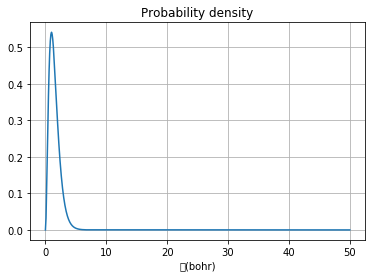

In [72]:
En = brentq(shoot,-1.5,-0.8,args=(Z,l,R))
print("E = ",En)
sol = odeint(odeSystem, iniValue, R, args=(En,Z,l))
Ur= normalise(sol[:,0])
#psi = [Ur[i]/R[i] for i in range(len(R))]
#plt.plot(R,psi)
plt.plot(R,Ur**2)
plt.title("Probability density")
plt.xlabel("\r(bohr)")
plt.grid()
plt.show()

We can verify that the probability is at its maximum at 1 a0 

In [73]:
ProbMaxAt=R[np.argmax(np.abs(Ur))]
print(ProbMaxAt)

1.00200400802


To find all the solutions (n,l)  where $0\le l<n-1$, i.e. $l \in \{0,1,..,n-1\}$


In [77]:
Nsearch = 500
Nmax = 3
lmax = Nmax-1
EigenValues = []
for l in range(Nmax): # or range(lmax+1)
    E0 = -2.0*Z*Z
    dE = 0.1
    Elevel = 0
    shootE0 = shoot(E0,Z,l,R)
    for n in range(Nsearch):
        shootE = shoot(E0+dE,Z,l,R)
        #if shoot(E0,Z,l,R)*shoot(E0+dE,Z,l,R)<0:
        if shootE0*shootE<0:
            EigEn = brentq(shoot,E0,E0+dE,args=(Z,l,R))   
            sol = odeint(odeSystem, iniValue, R, args=(EigEn,Z,l),mxstep=50000)
            Ur= normalise(sol[:,0])
            Elevel += 1
            print("n = ",Elevel+l,"l = ",l," E = ", EigEn)            
            EigenValues.append([Elevel+l,l,EigEn,Ur])     
        shootE0 = shootE
        E0 += dE
        #dE = dE
        if Elevel>=Nmax-l: break


n =  1 l =  0  E =  -1.000000014800591
n =  2 l =  0  E =  -0.24999999700810896
n =  3 l =  0  E =  -0.11110880529106307
n =  2 l =  1  E =  -0.2499999957316887


C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


n =  3 l =  1  E =  -0.11110912263016853
n =  3 l =  2  E =  -0.11111081390742793


Don't forget to reverse the order of calculated $U_r$, i.e. Ur = Ur[::-1]. We notice some instability in the solution, this is due to the point r=0. A logarithmic grid is more suitable as we will see later.

In [78]:
def getKey(itm): return itm[2]
S = sorted(EigenValues, key=getKey)
for t in S:
    print(t[:3])

[1, 0, -1.000000014800591]
[2, 0, -0.24999999700810896]
[2, 1, -0.2499999957316887]
[3, 2, -0.11111081390742793]
[3, 1, -0.11110912263016853]
[3, 0, -0.11110880529106307]


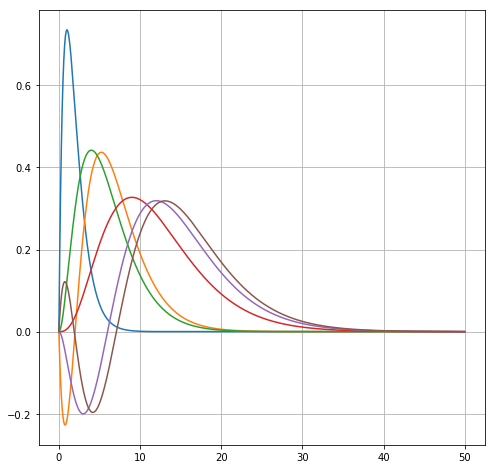

In [79]:
plt.figure(figsize=[8,8])
for g in S:
    plt.plot(R,g[3])
plt.grid()
plt.show()

# Logarithmic grid
As it can be seen from the form of the potential much of the physics happens near r=0. This makes a logarithmic grid more suitable. In the code below the grid is created from 1E-6 to 10E2.2.
In the function shoot, the value at 0 is extrapolated using polynomial(order 1) around R[0]=1E-6

In [2]:
import numpy as np
import scipy as sc
from scipy.integrate import odeint
from scipy.optimize import brentq

n   = 500
Z   = 1.0
l   = 0
R   = np.logspace(-6,2.2,n)
R_1 = R[::-1] # we start from rmax coming down to zero

def bound(UQ,r,E,l):
    return [UQ[1], -(E +2.0*Z/r -l*(l+1.0)/r**2)*UQ[0]]

def shoot(E,l):
    sol = odeint(bound, initialCond, R_1, args=(E,l))
    t = sol[:,0]
    t =t[::-1]/max(np.abs(t))
    tPrime = (t[1]-t[0])/(R[1]-R[0])
    return  t[0] + tPrime*(0.0-R[0])
   
initialCond = [0.0, -1E-4] # this is the initial value UQ

Nmax = 6        # max principal quantum number 
lmax = Nmax-1   # max orbital quantum number
maxsteps = 1000
en  = []
dE  = 0.1
dE_change = dE
for l in range(Nmax):
    E0 = -1.2*Z**2
    Elevel = 0    
    u0 = shoot(E0,l)
    for i in range(maxsteps):        
        E1 = E0 + dE        
        if E1>0: break
        u1 = shoot(E1,l)
        if u0*u1<0:
            Ex = brentq(shoot,E0,E1,args =(l,), xtol=1e-17)
            Elevel +=1       
            print([Elevel+l,l,Ex])
            en.append([Elevel+l,l,Ex])
            dE = dE/2             
        if Elevel>=Nmax-l: 
            dE = dE_change/1.5
            dE_change = dE
            print("new dE:",dE)
            break
        u0 = u1                   
        E0 +=dE
print("\n\nSorted states ")
print("[n, l, E]")
en.sort(key = lambda x: [np.round(x[2],3), x[1]])
for ss in en : print(ss)   
    

[1, 0, -1.0000000157946842]
[2, 0, -0.24999999729695033]
[3, 0, -0.11111111120336686]
[4, 0, -0.06250000027352948]
[5, 0, -0.04000000064682782]
[6, 0, -0.027777779980238174]
new dE: 0.06666666666666667
[2, 1, -0.24999999661894726]
[3, 1, -0.11111111244275512]
[4, 1, -0.06250000045520744]
[5, 1, -0.04000000025839595]
[6, 1, -0.02777777914601529]
new dE: 0.044444444444444446
[3, 2, -0.11111111357916441]
[4, 2, -0.06250000057701087]
[5, 2, -0.040000000731520574]
[6, 2, -0.027777778894871024]
new dE: 0.02962962962962963
[4, 3, -0.062499999827279475]
[5, 3, -0.040000000146287934]
[6, 3, -0.02777777828615454]
new dE: 0.019753086419753086
[5, 4, -0.0399999998846135]
[6, 4, -0.027777778161538483]
new dE: 0.01316872427983539
[6, 5, -0.02777777773755135]
new dE: 0.008779149519890261


 Sorted states 
[n, l, E]
[1, 0, -1.0000000157946842]
[2, 0, -0.24999999729695033]
[2, 1, -0.24999999661894726]
[3, 0, -0.11111111120336686]
[3, 1, -0.11111111244275512]
[3, 2, -0.11111111357916441]
[4, 0, -0.06250

There is room for improvement.. more will follow.